In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.utils import class_weight


In [12]:
datadir = '/Users/kesavreddy/Downloads/DataJPG'


In [13]:
category_dirs = [d for d in os.listdir(datadir) if os.path.isdir(os.path.join(datadir, d))]


In [14]:
img_size = 224
batch_size = 32
num_classes = len(category_dirs)

In [15]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    datadir,
    validation_split=0.2,
    subset="training",
    label_mode='categorical',
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    datadir,
    validation_split=0.2,
    subset="validation",
    label_mode='categorical',
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch_size
)

Found 42526 files belonging to 4 classes.
Using 34021 files for training.
Found 42526 files belonging to 4 classes.
Using 8505 files for validation.


In [18]:
true_labels = []
for _, labels in train_ds:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))

# Calculate class weights based on class distribution
class_counts = np.bincount(true_labels)
total_samples = len(true_labels)
class_weights = total_samples / (len(class_counts) * class_counts)

class_weights_dict = dict(enumerate(class_weights))

In [19]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top of the pre-trained model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)


In [20]:
history = model.fit(
    train_ds,
    epochs=15,
    validation_data=val_ds,
    callbacks=[early_stopping, lr_scheduler],
    class_weight=class_weights_dict  # Pass the computed class weights
)

Epoch 1/15


2023-11-15 03:18:34.012554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1064/1064 [==============================] - ETA: 0s - loss: 2.7968 - accuracy: 0.3465

2023-11-15 03:20:40.925618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1064/1064 [==============================] - 160s 145ms/step - loss: 2.7968 - accuracy: 0.3465 - val_loss: 1.1895 - val_accuracy: 0.4006 - lr: 0.0010
Epoch 2/15
1064/1064 [==============================] - 152s 142ms/step - loss: 2.1519 - accuracy: 0.3994 - val_loss: 1.6459 - val_accuracy: 0.3632 - lr: 0.0010
Epoch 3/15
1064/1064 [==============================] - 151s 141ms/step - loss: 1.6828 - accuracy: 0.4489 - val_loss: 1.0769 - val_accuracy: 0.5735 - lr: 0.0010
Epoch 4/15
1064/1064 [==============================] - 152s 142ms/step - loss: 1.5489 - accuracy: 0.4611 - val_loss: 1.4581 - val_accuracy: 0.3821 - lr: 0.0010
Epoch 5/15
1064/1064 [==============================] - 149s 140ms/step - loss: 1.3165 - accuracy: 0.4914 - val_loss: 0.9956 - val_accuracy: 0.5473 - lr: 0.0010
Epoch 6/15
1064/1064 [==============================] - 150s 140ms/step - loss: 1.1897 - accuracy: 0.5152 - val_loss: 0.7876 - val_accuracy: 0.7402 - lr: 0.0010
Epoch 7/15
1064/1064 [=======================

In [21]:
test_loss, test_acc = model.evaluate(val_ds)
print("Test accuracy:", test_acc)

266/266 [==============================] - 39s 145ms/step - loss: 0.6194 - accuracy: 0.7440
Test accuracy: 0.7440329194068909


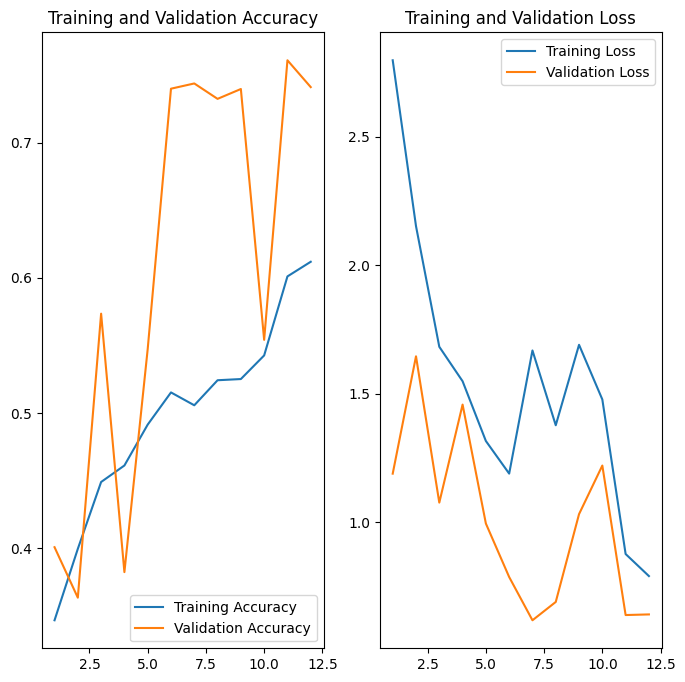

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
def get_class_names_from_one_hot(encoded_labels, class_names):
    return [class_names[label] for label in np.argmax(encoded_labels, axis=1)]


In [24]:
train_y_true = []
train_y_pred = []

for x, y in train_ds:
    train_y_true.extend(np.argmax(y.numpy(), axis=1))
    train_y_pred.extend(np.argmax(model.predict(x), axis=1))

train_y_true_class_names = get_class_names_from_one_hot(tf.keras.utils.to_categorical(train_y_true, num_classes), category_dirs)
train_y_pred_class_names = get_class_names_from_one_hot(tf.keras.utils.to_categorical(train_y_pred, num_classes), category_dirs)

class_names = {'A': 'Adinocarcinoma', 'B': 'Small Cell carcinoma', 'E': 'Large Cell Carcinoma', 'G': 'Squamous Cell Carcinoma'}

for i in range(len(train_y_pred_class_names)):
    predicted_class_name = class_names[train_y_pred_class_names[i]]
    actual_class_name = class_names[train_y_true_class_names[i]]
    print(f"Predicted: {predicted_class_name}, Actual: {actual_class_name}")


2023-11-15 03:53:38.419918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 79ms/step


2023-11-15 03:56:46.324958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step
Predicted: Squamous Cell Carcinoma, Actual: Adinocarcinoma
Predicted: Squamous Cell Carcinoma, Actual: Squamous Cell Carcinoma
Predicted: Squamous Cell Carcinoma, Actual: Squamous Cell Carcinoma
Predicted: Small Cell carcinoma, Actual: Small Cell carcinoma
Predicted: Squamous Cell Carcinoma, Actual: Squamous Cell Carcinoma
Predicted: Small Cell carcinoma, Actual: Squamous Cell Carcinoma
Predicted: Squamous Cell Carcinoma, Actual: Squamous Cell Carcinoma
Predicted: Squamous Cell Carcinoma, Actual: Squamous Cell Carcinoma
Predicted: Squamous Cell Carcinoma, Actual: Squamous Cell Carcinoma
Predicted: Squamous Cell Carcinoma, Actual: Squamous Cell Carcinoma
Predicted: Small Cell carcinoma, Actual: Small Cell carcinoma
Predicted: Squamous Cell Carcinoma, Actual: Small Cell carcinoma
Predicted: Squamous Cell Carcinoma, Actual: Squamous Cell Carcinoma
Predicted: Small Cell carcinoma, Actual: Squamous Cell Carcinoma
Predicted: Squamous Cell Car

In [25]:
train_accuracy = accuracy_score(train_y_true, train_y_pred)
train_recall = recall_score(train_y_true, train_y_pred, average='weighted')
train_precision = precision_score(train_y_true, train_y_pred, average='weighted', zero_division=0)
train_f1 = f1_score(train_y_true, train_y_pred, average='weighted')

print("Training Accuracy:", train_accuracy)
print("Training Recall:", train_recall)
print("Training Precision:", train_precision)
print("Training F1 Score:", train_f1)

Training Accuracy: 0.7391317127656447
Training Recall: 0.7391317127656447
Training Precision: 0.7229382815597452
Training F1 Score: 0.6888068008098646


In [26]:
model.save("DENSENET.h5")
print("Model saved successfully.")

/Users/kesavreddy/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully.
